In [2]:
import numpy as np
import scipy.io
from scipy import stats
import matplotlib.pylab as plt
from scipy.stats import cosine
import pandas as pd
from multiprocessing import Pool
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time
from itertools import repeat
import  seaborn as sns
from os import path

import numpy as np

from yt.units import G
import array
import pandas as pd
import matplotlib.colors as mcolors
import matplotlib
from sklearn.linear_model import LinearRegression

seconds_to_Myr = 3.15576e+16

import warnings
warnings.filterwarnings("ignore")
import cmasher as cmr
import sys
 
sys.path.append('/home/bego/GARROTXA//GalaDyn/')

from snapshot_definition import *
from config import *

from matplotlib import rcParams 
rcParams['axes.formatter.use_mathtext'] = True


class OOMFormatter(matplotlib.ticker.ScalarFormatter):
    def __init__(self, order=0, fformat="%1.1f", offset=True, mathText=True):
        self.oom = order
        self.fformat = fformat
        matplotlib.ticker.ScalarFormatter.__init__(self,useOffset=offset,useMathText=mathText)
    def _set_order_of_magnitude(self):
        self.orderOfMagnitude = self.oom
    def _set_format(self, vmin=None, vmax=None):
        self.format = self.fformat
        if self._useMathText:
            self.format = r'$\mathdefault{%s}$' % self.format

In [3]:
snapshot = Snapshot(999)

snapshot.load_stars()
snapshot.load_classification()
#df_old_disk = snapshot.filter_old_disk()
#df_disk =  snapshot.filter_disk_particles_by_age()
df_ellipsoid =  snapshot.filter_stellar_ellipsoid()

disk_total = snapshot.filter_all_disk()


Initializing snapshot 999
Lookback time: 0.0132086769907413 Gyr


In [4]:

disk_total["Age_Gyr"] = disk_total["Age"]/1000

df_ellipsoid["Age_Gyr"] = df_ellipsoid["Age"]/1000

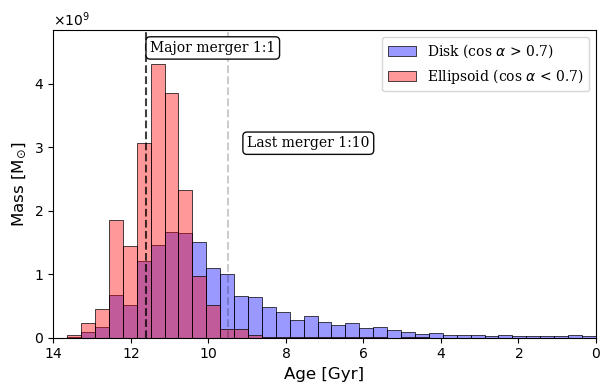

In [5]:
props = dict(boxstyle='round', facecolor='white', alpha=0.95)
bins_hist = np.linspace(0, 14, 40)


fig, ax = plt.subplots(1,1,figsize = (7,4), sharex=True)
plt.rc('font', family='serif')


g = sns.histplot(disk_total, x="Age_Gyr", weights = "Mass", bins =bins_hist, color = "blue", 
                 alpha = 0.4, linewidth=0.5, label= r"Disk (cos $\alpha$ > 0.7)")
g= sns.histplot(df_ellipsoid, x="Age_Gyr", weights = "Mass",bins =bins_hist, color = "red",
                alpha = 0.4, linewidth=0.5,  label= r"Ellipsoid (cos $\alpha$ < 0.7)")

ax.set_xlabel (r"Age [Gyr]", fontsize = 12)
ax.set_ylabel (r"Mass [M$_{\odot}$]", fontsize = 12)


ax.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
ax.tick_params(labelsize = 10)
ax.set_xlim(14,0)

ax.legend(fontsize = 10)

ax.axvline(x =9.5 , color = 'black', ls = "--", alpha = 0.2)
ax.axvline(x =11.6 , color = 'black', ls = "--", alpha = 0.75)

ax.text(x=11.5, y=4.5e9, s= "Major merger 1:1", fontsize=10,bbox=props)
ax.text(x=9, y=3e9, s= "Last merger 1:10", fontsize=10,bbox=props)

ax.set_ylim(0,4.85e9)
#plt.savefig("Figuras/particle_mass_age.jpg", dpi = 100, bbox_inches = "tight")
plt.show()

In [6]:
stars = snapshot.stars
snapshot.load_classification()
data = snapshot.classification

In [7]:
df = pd.merge(stars, data[["ID", "JzJc", "cos_alpha"]], on="ID")

#We now divide young disk from old disk and then the ellipsoid
df_sat = df[(np.sqrt(df["X"]**2 + df["Y"]**2 +df["Z"]**2)>30)].copy()
df_ref = df[np.sqrt(df["X"]**2 + df["Y"]**2 +df["Z"]**2)<=30].copy()

df_disco = df_ref[(df_ref["Age"]<9100)].copy()
df_nodisc_re = df_ref[~df_ref['ID'].isin(df_disco["ID"])]
df_old_disc = df_nodisc_re[df_nodisc_re["cos_alpha"]>0.7].copy()

df_ellipsoid = df_nodisc_re[(df_nodisc_re["cos_alpha"]<0.7)].copy()


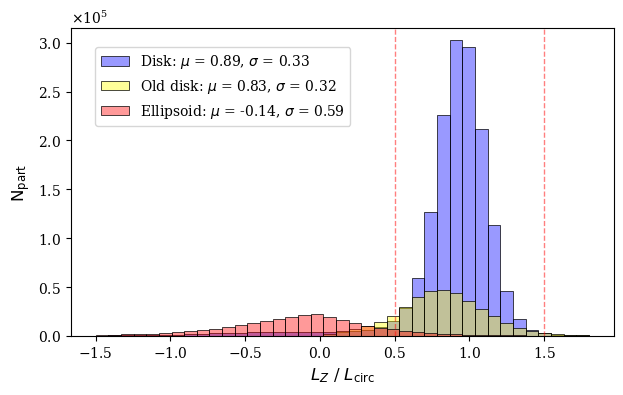

In [8]:
plt.rc('font', family='serif')
bins_hist = np.linspace(-1.5, 1.8, 40)
#style.use('bmh') or plt.style.use('bmh')
fig = plt.figure(figsize=(7,4))


g = sns.histplot(df_disco, x="JzJc", bins =bins_hist, color = "blue", alpha = 0.4, 
                 linewidth=0.5, 
    label = "Disk: "+ "$\mu$ = " + f"{np.mean(df_disco['JzJc']):.2f}" + r", $\sigma$ = "+ f"{np.std(df_disco['JzJc']):.2f}")
g= sns.histplot(df_old_disc, x="JzJc", bins =bins_hist,color = "yellow", alpha = 0.4, linewidth=0.5,
               label = "Old disk: "+ "$\mu$ = " + f"{np.mean(df_old_disc['JzJc']):.2f}" + r", $\sigma$ = "+ f"{np.std(df_old_disc['JzJc']):.2f}")
g = sns.histplot(df_ellipsoid, x="JzJc", bins =bins_hist, color = "red", alpha = 0.4, linewidth=0.5,
                label = "Ellipsoid: "+ "$\mu$ = " + f"{np.mean(df_ellipsoid['JzJc']):.2f}" + r", $\sigma$ = "+ f"{np.std(df_ellipsoid['JzJc']):.2f}")

#g = sns.histplot(df_bar, x="JzJc", bins =bins_hist, color = "green", alpha = 0.4)
#fig.legend(labels=[r'Disk', "Old disk", "Ellipsoid"], loc ="upper left",bbox_to_anchor=(0.15, 0.85), fontsize = 12)
fig.legend(loc ="upper left",bbox_to_anchor=(0.15, 0.85), fontsize = 10)
plt.xlabel (r"$L_{Z}$ / $L_{\mathrm{circ}}$", fontsize = 12)
plt.ylabel (r"$\mathrm{N}_{\mathrm{part}}$", fontsize = 12)
plt.ylim(0, 3.15e5)
plt.axvline(x = 0.5, color = "red", ls = "--", lw = 1, alpha = 0.5)
plt.axvline(x = 1.5, color = "red", ls = "--", lw = 1, alpha = 0.5)
#plt.ticklabel_format(style='sci', axis='y')
plt.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
plt.tick_params(labelsize = 10)
#plt.savefig("histogramjzjcirc.jpg", dpi = 100, bbox_inches = "tight")
plt.show()

In [9]:
def draw_projections (axis,df ):
    rangex=[-25,25]
    rangey=[-25,25]
    binsx=130
    binsy=130

    surface = (((rangex[1]-rangex[0])/binsx)**2)*1e6
    aspect=(rangex[1]-rangex[0])/(rangey[1]-rangey[0])
    deltax=(rangex[1]-rangex[0])/binsx
    deltay=(rangey[1]-rangey[0])/binsy

    stat0=stats.binned_statistic_2d(df["X"], df["Z"], df['Mass']/surface, statistic='sum', bins=(binsx,binsy), range=[rangex,rangey])
    im_nodisc=np.flip(stat0.statistic.T*1.,0)
    den = ax[0,axis].imshow(np.log10(im_nodisc),cmap='inferno_r', extent=[rangex[0],rangex[1],rangey[0],rangey[1]],
                         aspect=aspect, vmin = -0.5, vmax =2.5)

    stat0=stats.binned_statistic_2d(df["X"], df["Y"], df['Mass']/surface, statistic='sum', bins=(binsx,binsy), range=[rangex,rangey])
    im_nodisc=np.flip(stat0.statistic.T*1.,0)
    den = ax[1,axis].imshow(np.log10(im_nodisc),cmap='inferno_r', extent=[rangex[0],rangex[1],rangey[0],rangey[1]],aspect=aspect, 
                         vmin = -0.5, vmax =2.5)

    stat0=stats.binned_statistic_2d(df["X"], df["Y"], df['Age']/1000, statistic='mean', bins=(binsx,binsy), range=[rangex,rangey])
    im_nodisc=np.flip(stat0.statistic.T*1.,0)
    vz = ax[2,axis].imshow(im_nodisc,cmap='rainbow', extent=[rangex[0],rangex[1],rangey[0],rangey[1]],aspect=aspect, 
                        vmin = 6, vmax = 11.5)

    return den,vz

    

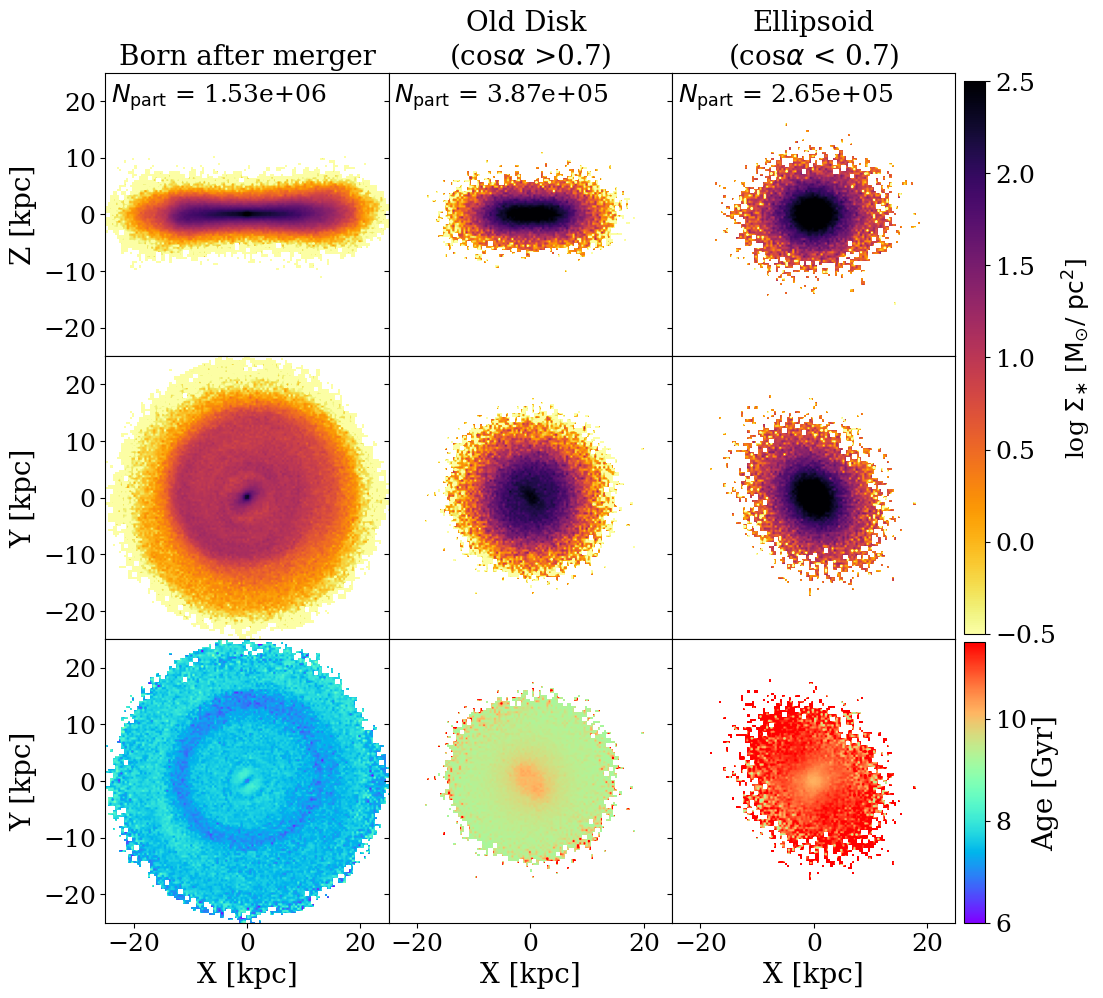

In [10]:
plt.rc('font', family='serif')
fig, ax = plt.subplots(3,3,figsize = (8.5,8.5),sharex = True,sharey = True)


den, vz = draw_projections (0, df_disco)
den, vz = draw_projections (1, df_old_disc)
den, vz = draw_projections (2, df_ellipsoid)


props = dict(boxstyle='round', facecolor='white', alpha=0.8)


ax[0,0].set_title("Born after merger", fontsize = 20)
ax[0,1].set_title("Old Disk \n" + r"(cos$\alpha$ >0.7)", fontsize = 20)
ax[0,2].set_title("Ellipsoid\n" + r"(cos$\alpha$ < 0.7)", fontsize = 20)


ax[0,0].text(0.02, 0.97,  "$N_{\mathrm{part}}$" + f" = {len(df_disco):.2e}", transform=ax[0,0].transAxes, fontsize=18,
        verticalalignment='top')
ax[0,1].text(0.02, 0.97,  "$N_{\mathrm{part}}$" + f" = {len(df_old_disc):.2e}", transform=ax[0,1].transAxes, fontsize=18,
        verticalalignment='top')
ax[0,2].text(0.02, 0.97, "$N_{\mathrm{part}}$" + f" = {len(df_ellipsoid):.2e}", transform=ax[0,2].transAxes, fontsize=18,
        verticalalignment='top')


cbar_ax = fig.add_axes([ 1.01, 0.34 ,0.025, 0.65])
cbar = fig.colorbar(den, cax=cbar_ax,orientation='vertical')          
cbar.ax.tick_params(labelsize= 18,top= True,bottom= False,
                    labeltop=True,  labelbottom= False)
cbar.set_label(label=r"log $\Sigma_{\ast}$ [$\mathrm{M_{\odot}}$/ $\mathrm{pc^2}$]", size = 18)
cbar.ax.tick_params(labelsize= 18)


cbar_ax = fig.add_axes([ 1.01, 0, 0.025, 0.33])
cbar = fig.colorbar(vz, cax=cbar_ax,orientation='vertical')          
cbar.ax.tick_params(labelsize= 18,top= True,bottom= False,
                    labeltop=True,  labelbottom= False)
cbar.set_label(label=f"Age [Gyr]", size = 20)
cbar.ax.tick_params(labelsize= 18)

for i in range(3):
    ax[2,i].set_xlabel("X [kpc]", fontsize = 20)
    for j in range(3):
        ax[j,i].tick_params(labelsize = 18)

ax[0,0].set_ylabel("Z [kpc]", fontsize = 20)
ax[1,0].set_ylabel("Y [kpc]", fontsize = 20)
ax[2,0].set_ylabel("Y [kpc]", fontsize = 20)

plt.subplots_adjust(left=0 ,bottom= 0., right=1, top=1, wspace=0.0, hspace= 0.0)

#plt.show()#
#plt.savefig(f"disc_nondisc_example.jpg", dpi = 120, facecolor = "white", bbox_inches = "tight")